# Pendulum with Structured LNN and Control
- We know the data is angle and use it as advantage

## TODO:

- Plot Mass Matrix
- Plot Potential
- Understand the control

In [1]:
import numpy as np
import torch

import sys
import time
sys.path.append("../../")

## Train Model

In [2]:
# hparams
num_sample = 10000
batch_size = 128
portion = 0.5

learning_rate = 3e-4
min_delta = 0
patience = 50

time_horizon = 5
solver = 'rk4'

model_name = 'latent.pt'
# Check Model params in Model section

### Set Seed Here

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

### Load the data set
- init_condition: list of tuple

 [(x0, p0, t0, t1, steps)]

In [4]:
from gym_env import PendulumCustomEnv
from data import Gym_DataModule_rng

In [5]:
env = PendulumCustomEnv(full_phase=True)
low = np.array([-2])
high = -low

# env, time step, traj, control
dataModule = Gym_DataModule_rng(env,
                                num_sample,
                                low=low,
                                high=high,
                                no_act_portion=portion,
                                time_horizon=time_horizon,
                                batch_size=batch_size,
                                data_dir='../../data/dataset',
                                use_img=True)

dataModule.setup()

In [6]:
print(dataModule.dataset.tensors[0].shape)  # (bs, time, [cos q, sin, q, dq])
print(dataModule.dataset.tensors[1].shape)  # (bs, time, [control])
print(dataModule.dataset.tensors[2].shape)  # (bs, time, [time])
print(dataModule.dataset.tensors[3].shape)  # (bs, time, [th, dth, ddth])
print(dataModule.dataset.tensors[4].shape)  # (bs, time, images)

torch.Size([10000, 5, 3])
torch.Size([10000, 5, 1])
torch.Size([10000, 5, 1])
torch.Size([10000, 5, 3])
torch.Size([10000, 5, 28, 28, 2])


### Define Model

In [7]:
from torchdyn.models import NeuralODE

from module.LNNODE_latent import LNNODE_latent
from nn import MLP, PSD, MatrixNet

In [8]:
massMatrixNet = PSD([1, 64, 64, 1], activation='relu')
potentialNet = MLP([1, 64, 64, 1], activation='relu')
controlNet = MatrixNet([1, 64, 64, 1], control_dim=1, activation='relu')

lagFunc = LNNODE_latent(num_angle=0, 
                        massMatrixNet=massMatrixNet,
                        potentialNet=potentialNet,
                        controlNet=controlNet)

lagODE = NeuralODE(lagFunc, sensitivity='adjoint', solver=solver).to(device)

In [9]:
torch.save(lagODE, 'models/before_{}'.format(model_name))

### Define Pytorch lightning trainer

In [10]:
import torch.nn.functional as F

import pytorch_lightning as pl

from pytorch_lightning.callbacks import EarlyStopping

In [11]:
class Learner(pl.LightningModule):
    def __init__(self, model: torch.nn.Module):
        super().__init__()
        self.model = model
        self.loss_func = F.mse_loss

    def forward(self, x):
        return self.model.defunc(0, x)

    def training_step(self, batch, batch_idx):
        stat = self.step(batch, batch_idx)
        self.logger.experiment.add_scalars("loss", {"train": stat['loss']}, self.current_epoch)
        return stat
    
    def validation_step(self, batch, batch_idx):
        stat = self.step(batch, batch_idx)
        self.log('val_loss', stat['loss'])
        self.logger.experiment.add_scalars("loss", {"val": stat['loss']}, self.current_epoch)
        return stat

    def step(self, batch, batch_idx):
        _, u, t, info, imgs = batch
        t_span = t[0, :, 0]
        bs = imgs.shape[0]
        time_horizon = t.shape[1]

        # Get image distance
        imgs_flatten = imgs.reshape(bs * time_horizon, -1)
        imgs_time_flatten = imgs.reshape(bs, time_horizon, -1)
        
        imgs_distM = torch.cdist(imgs_flatten, imgs_flatten, p=2)
        imgs_time_distM = torch.cdist(imgs_time_flatten, imgs_time_flatten, p=2)

        z = self.model.defunc.m.encoder(imgs)
        z_flatten = z.reshape(bs * time_horizon, -1)
        z_time_flatten = z.reshape(bs, time_horizon, -1)
        
        z_distM = torch.cdist(z_flatten, z_flatten, p=2)
        z_time_distM = torch.cdist(z_time_flatten, z_time_flatten, p=2)

        imgs_hat = self.model.defunc.m.decoder(z)

        recon_loss = self.loss_func(imgs, imgs_hat)
        dimg_loss = self.loss_func(imgs[:, 1:, :, :, 0] - imgs[:, :-1, :, :, 0], imgs_hat[:, 1:, :, :, 1])
        dist_loss = self.loss_func(torch.nn.functional.normalize(imgs_distM),
                                   torch.nn.functional.normalize(z_distM))
        
        # dist_time_loss = self.loss_func(torch.nn.functional.normalize(imgs_time_distM),
        #                                 torch.nn.functional.normalize(z_time_distM))
        dist_time_loss = self.loss_func(imgs_time_distM,
                                        z_time_distM)

        loss = 0
        loss += recon_loss
        # loss += dist_loss * 256
        loss += dist_time_loss * 1024

        return {'loss': loss, 'recon_loss': recon_loss, 'dist_loss': dist_loss, 'dist_time': dist_time_loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=learning_rate)

    def training_epoch_end(self, outputs):
        print("\n recon: {:3e}, dist {:3e}, dist_time {:3e} \n".format(outputs[-1]['recon_loss'],
                                                                       outputs[-1]['dist_loss'],
                                                                       outputs[-1]['dist_time']))

In [12]:
learn = Learner(lagODE)

early_stopping = EarlyStopping('val_loss', verbose=True, min_delta=min_delta, patience=patience)
trainer = pl.Trainer(callbacks=[early_stopping], min_epochs=500, max_epochs=5000)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


### Train

In [13]:
start_time = time.time()

In [14]:
trainer.fit(learn, dataModule)


  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 2.2 M 
------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.850     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:348: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to impro

Training: 0it [00:00, ?it/s]


 recon: 3.691339e-03, dist 8.060847e-04, dist_time 9.753731e-01 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 900.646
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:610: LightningDeprecationWarning: Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.
  warning_cache.deprecation(



 recon: 3.861124e-03, dist 7.879255e-04, dist_time 8.879390e-01 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 103.767 >= min_delta = 0. New best score: 796.879



 recon: 3.602547e-03, dist 7.939901e-04, dist_time 6.690899e-01 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 39.344 >= min_delta = 0. New best score: 757.535



 recon: 3.753449e-03, dist 7.916287e-04, dist_time 6.897916e-01 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 30.320 >= min_delta = 0. New best score: 727.216



 recon: 3.652658e-03, dist 8.147756e-04, dist_time 6.580190e-01 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 28.562 >= min_delta = 0. New best score: 698.654



 recon: 3.697062e-03, dist 7.983493e-04, dist_time 6.348547e-01 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 16.437 >= min_delta = 0. New best score: 682.217



 recon: 3.707067e-03, dist 7.989110e-04, dist_time 5.873685e-01 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 20.053 >= min_delta = 0. New best score: 662.163



 recon: 3.610753e-03, dist 7.980439e-04, dist_time 5.409180e-01 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 9.762 >= min_delta = 0. New best score: 652.402



 recon: 3.711059e-03, dist 8.112494e-04, dist_time 5.480411e-01 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 10.726 >= min_delta = 0. New best score: 641.676



 recon: 3.675007e-03, dist 8.117965e-04, dist_time 5.976495e-01 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 11.175 >= min_delta = 0. New best score: 630.500



 recon: 3.686575e-03, dist 8.134062e-04, dist_time 6.049325e-01 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 9.091 >= min_delta = 0. New best score: 621.409
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:897: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn('Detected KeyboardInterrupt, attempting graceful shutdown...')


In [15]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 135.08768510818481 seconds ---


### Save Model
- Pytorch Lightning model check point is buggy
- Use Pytorch save and load method instead

In [16]:
torch.save(lagODE, 'models/{}'.format(model_name))

## Model Analysis

In [17]:
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator

### Load Model

In [18]:
test_model = torch.load('models/{}'.format(model_name))
test_model.eval()

test_model = test_model

### Generate trajectory with Gym Env

In [19]:
# define testing time stamp
dt = 0.05
full = 100
t_span = torch.linspace(dt, dt*full, full)

In [20]:
import cv2
def preproc_pend(img):
    gray = cv2.cvtColor(img[220: 780, 220: 780, :], cv2.COLOR_BGR2GRAY)  # Grey Scale
    img = cv2.resize(gray, [28, 28])  # Rescale image
    img[img == 255] = 0  # Black background (0 seems better for training)
    output = img / 255
    return output

In [21]:
# Generate Trajectory
env.seed(0)
np.random.seed(0)

env = PendulumCustomEnv()
obs = []
infos = []
images = []

# control = 2
# controls = np.random.randint(-2, 2 + 1, full+1)
split = 20
controls = np.random.randint(-2, 2 + 1, int(full / split))
controls = np.repeat(controls, split)
controls = np.zeros_like(controls)

# obs0, _ = env.reset(np.array([3., 1.]))
obs0, _ = env.reset(np.array([np.pi / 2, 0.]))

prev_obs = obs0
prev_img = env.render('rgb_array')

for i in range(full):
    obs.append(prev_obs)
    images.append(preproc_pend(prev_img))
    
    next_obs, reward, done, info = env.step(controls[i])
    next_img = env.render('rgb_array')
    
    infos.append(np.array([info['th'], info['dth'], info['ddth']]))
    
    prev_obs = next_obs
    prev_img = next_img

obs = torch.tensor(obs)
infos = torch.tensor(infos)
imgs = torch.tensor(images)
controls = torch.Tensor(controls).view(-1, 1)
env.close()

### Generate Prediction

In [22]:
P = imgs[1:, :, :]
dP = imgs[1:, :, :] -imgs[: -1, :, :]
P_dP = torch.stack([P, dP], dim=3)

In [23]:
P_dP.shape
infos.shape

torch.Size([100, 3])

In [24]:
z = test_model.defunc.m.encoder(P_dP.view(-1, *P_dP.shape).float())

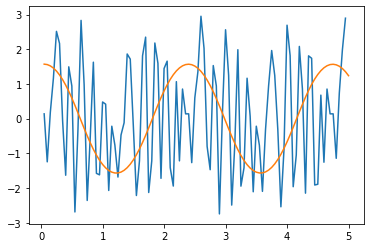

In [25]:
plt.plot(t_span[:full-1].detach().numpy(), z[0, :, 0].detach().numpy())
plt.plot(t_span.detach().numpy(), infos[:, 0].detach().numpy())
# plt.ylim(-4, 4)

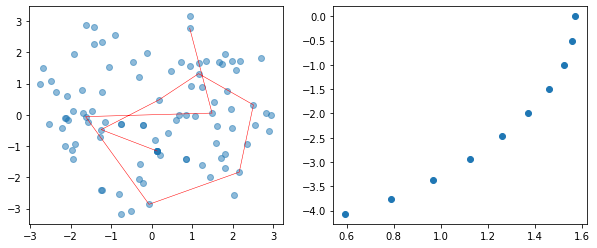

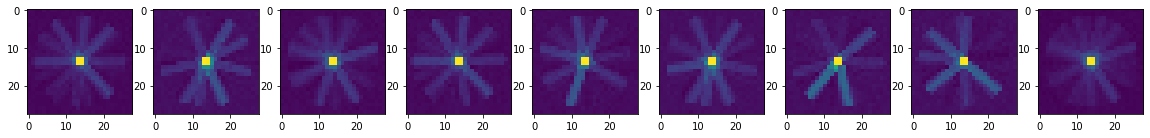

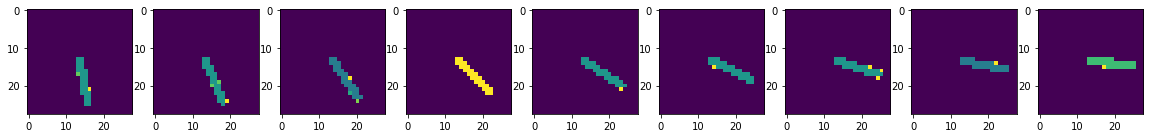

In [26]:
start = 35
length = 10

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(z[0, :, 0].detach().numpy(), z[0, :, 1].detach().numpy(), alpha=0.5)
ax1.plot(z[0, 0:length, 0].detach().numpy(), z[0, 0:length, 1].detach().numpy(), 'r-', linewidth=0.5)
ax2.scatter(infos[:length, 0], infos[:length, 1])

fig1 = plt.figure(figsize=(20, 4))
fig2 = plt.figure(figsize=(20, 4))
ax1s = [fig1.add_subplot(191+i) for i in range(9)]
ax2s = [fig2.add_subplot(191+i) for i in range(9)]

test_img = test_model.defunc.m.decoder(z)
for i in range(9):
    ax1s[i].imshow(test_img[0, start + i, :, :, 0].detach().numpy())
    ax2s[i].imshow(P_dP[start + i, :, :, 0].detach().numpy())

In [27]:
z_raw = test_model.defunc.m.encoder(dataModule.dataset.tensors[4].float())

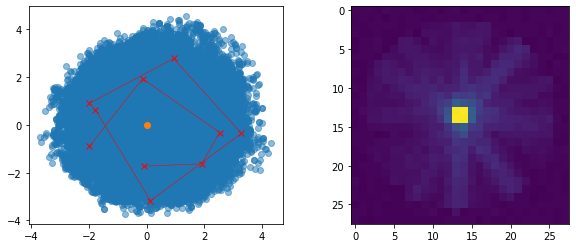

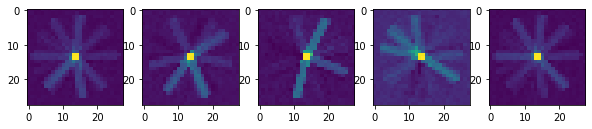

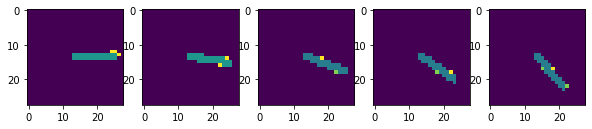

In [42]:
t = 20
bs = 10
test_pt = torch.tensor([0.0, 0.]).float()
test_img = test_model.defunc.m.decoder(test_pt.view(1, 1, -1))

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(z_raw[:, :, 0].detach().numpy(), z_raw[:, :, 1].detach().numpy(), alpha=0.5)
# idx = np.random.randint(0, 10000, (10, ))
idx = range(bs, bs+2)
for j in idx:
    ax1.plot(z_raw[j, :, 0].detach().numpy(), z_raw[j, :, 1].detach().numpy(), 'rx-', linewidth=0.5)
# ax1.plot(z_raw[bs, :, 0].detach().numpy(), z_raw[bs, :, 1].detach().numpy(), 'rx-', linewidth=0.5)

ax1.scatter(test_pt[0].detach().numpy(), test_pt[1].detach().numpy())
ax2.imshow(test_img[0, 0, :, :, 0].detach().numpy())

fig1 = plt.figure(figsize=(10, 4))
fig2 = plt.figure(figsize=(10, 4))
ax1s = [fig1.add_subplot(201+ time_horizon*10 +i) for i in range(time_horizon)]
ax2s = [fig2.add_subplot(201+ time_horizon*10 +i) for i in range(time_horizon)]

test_img = test_model.defunc.m.decoder(z_raw[[bs], :, :])
for i in range(time_horizon):
    ax1s[i].imshow(test_img[0, i, :, :, 0].detach().numpy())
    ax2s[i].imshow(dataModule.dataset.tensors[4][bs, i, :, :, 0].detach().numpy())

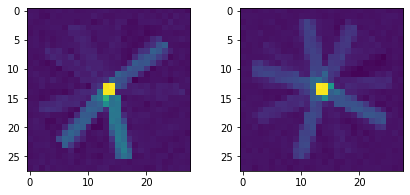

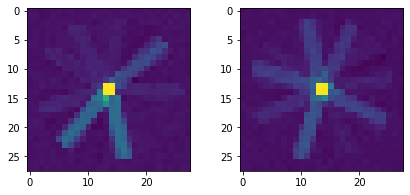

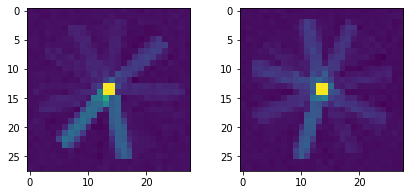

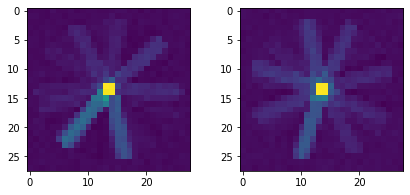

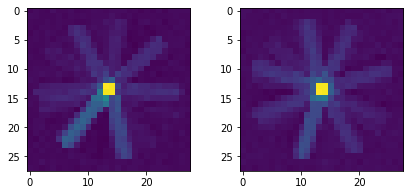

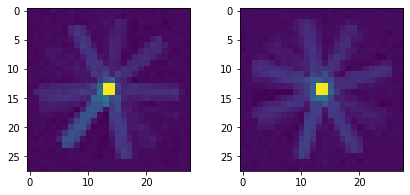

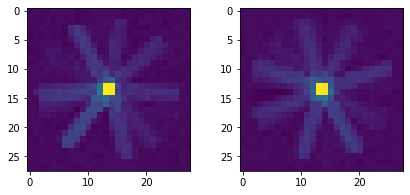

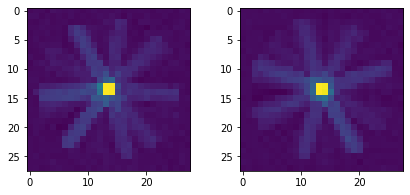

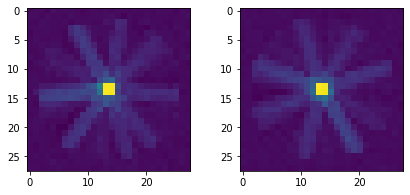

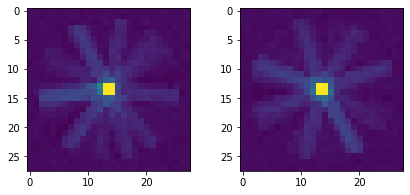

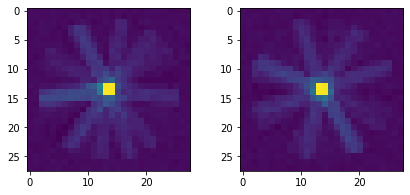

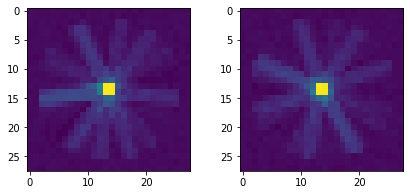

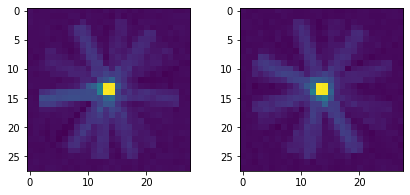

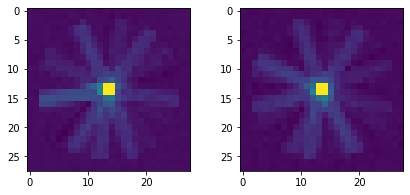

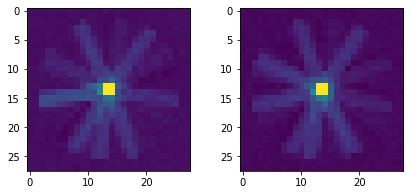

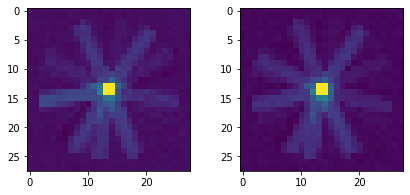

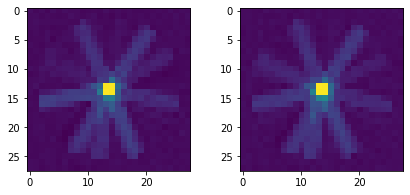

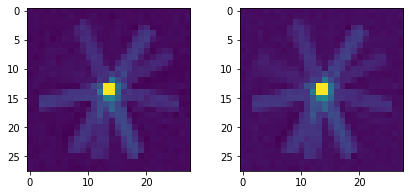

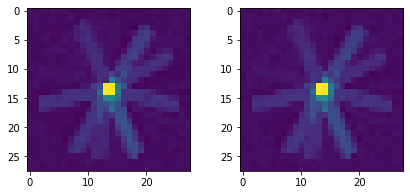

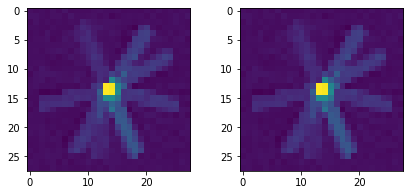

In [29]:
span = np.linspace(-2, 2, 20)
for i in span:
    
    fig = plt.figure(figsize=(7, 3))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    test1 = test_model.defunc.m.decoder(torch.tensor([i, 2.]).float().view(1, 1, -1)).reshape(1, 28, 28, 2)
    test2 = test_model.defunc.m.decoder(torch.tensor([2, i]).float().view(1, 1, -1)).reshape(1, 28, 28, 2)

    ax1.imshow(test1[0, :, :, 0].detach().numpy())
    ax2.imshow(test2[0, :, :, 0].detach().numpy())

In [30]:
from utils import traj_pred

# Generate prediction

q_dq_u = torch.cat([z[0, :, :], controls[1:, :]], dim=1)
q_dq = z[0, :, :]
est_grad = test_model.defunc(0, q_dq_u.float())
est_z = traj_pred(0.05, test_model, q_dq[0, :].detach().numpy(), controls)

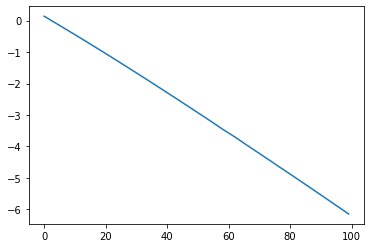

In [31]:
plt.plot(est_z.y[0, :])

In [32]:
est_z2 = torch.tensor(est_z.y.T)
est_z2.shape

torch.Size([100, 2])

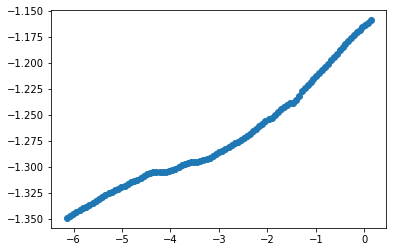

In [33]:
plt.scatter(est_z2[:, 0], est_z2[:, 1])

In [34]:
# recon_img = test_model.defunc.m.decoder(est_z2.float())
recon_img = test_model.defunc.m.decoder(z.float())

In [35]:
recon_img = recon_img.reshape(full-1, 28, 28, 2)

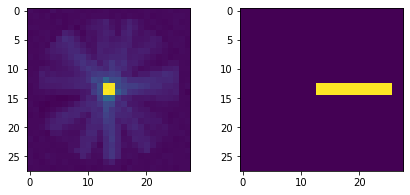

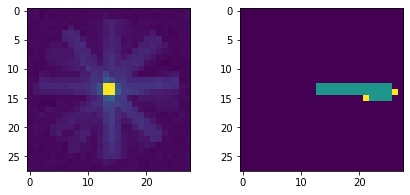

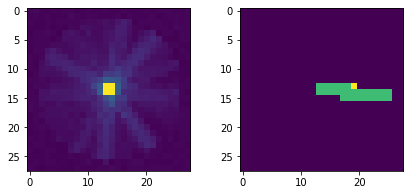

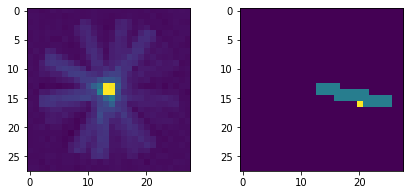

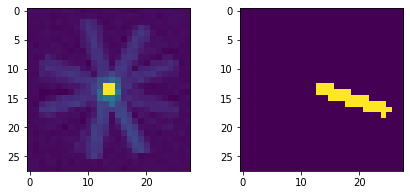

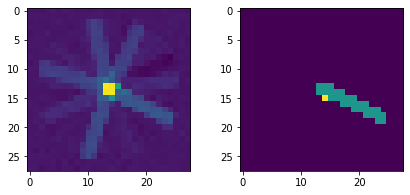

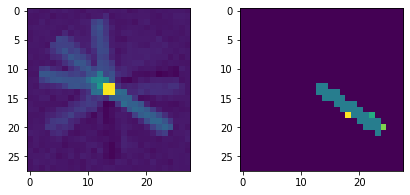

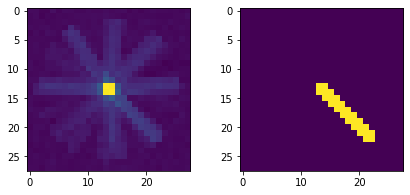

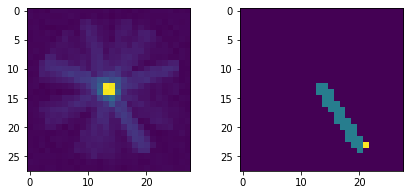

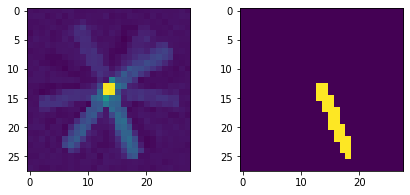

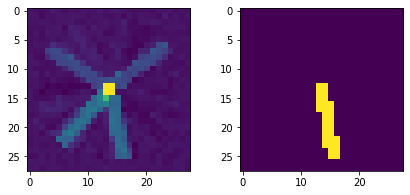

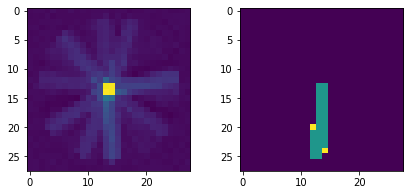

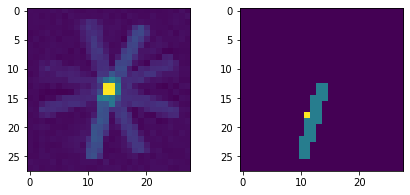

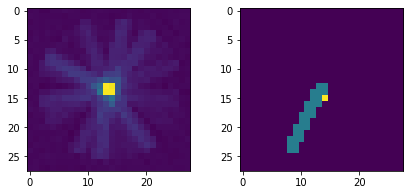

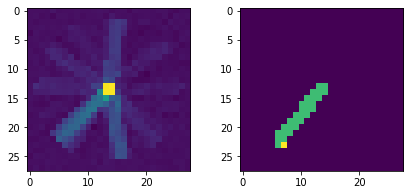

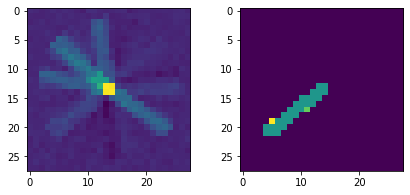

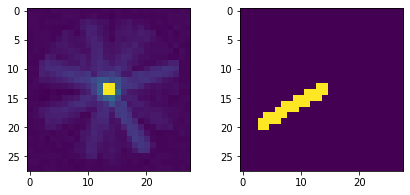

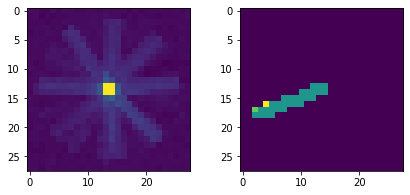

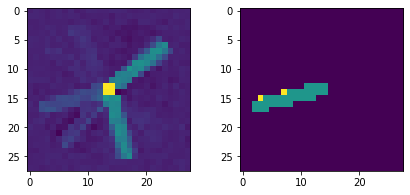

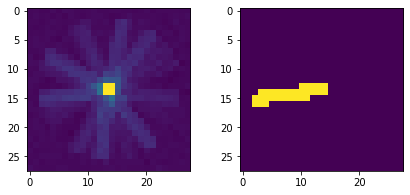

In [36]:
num_iters = 20

for i in range(num_iters):
    fig = plt.figure(figsize=(7, 3))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    ax1.imshow(recon_img[i, :, :, 0].detach().numpy())
    ax2.imshow(P_dP[i, :, :, 0].detach().numpy())

In [37]:
from scipy.integrate import solve_ivp

def dummy(t, y):
    idx = int(torch.tensor(t) / dt)
    dx1 = np.multiply(-y[1], y[2])
    dx2 = np.multiply(y[0], y[2])
    ddq = -10 * y[0] + controls[idx-1] / 2.
    return [dx1, dx2, ddq]

sol = solve_ivp(dummy, [dt, dt*full], obs0, method='Radau', t_eval=t_span.detach().numpy())

In [38]:
print(sol.y.shape)
print(obs0)
# sol.t

(3, 100)
[ 1.000000e+00 -6.123234e-17  0.000000e+00]


### Check gradient

ValueError: x and y must have same first dimension, but have shapes (100,) and (99,)

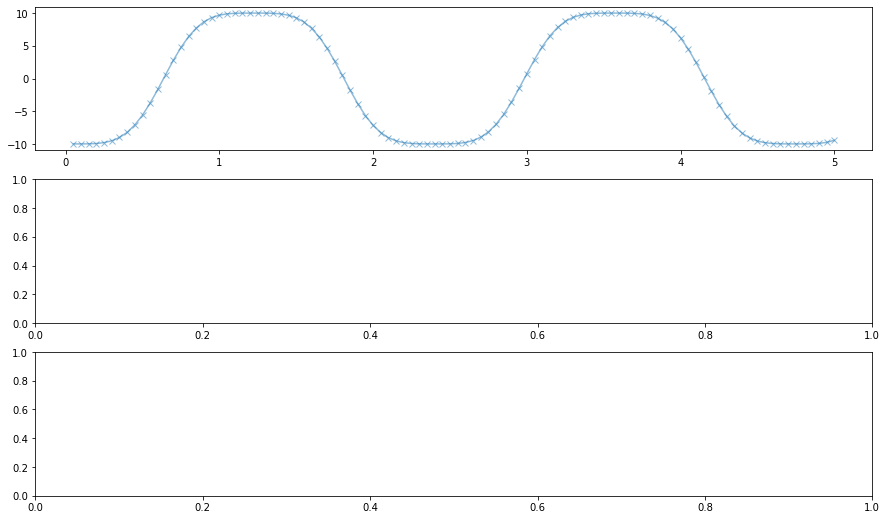

In [39]:
fig = plt.figure(figsize=(15, 9))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

start = 0
end = 500

# Check ddq_est
ax1.plot(t_span.detach().numpy()[start:end], infos[start:end, 2],'x-', alpha=0.5)  # Ground truth
ax1.plot(t_span.detach().numpy()[start:end], est_grad[start:end, 2].detach().numpy(), '--')  # LNN

# check dq_est
ax2.plot(t_span.detach().numpy()[start:end], infos[start:end, 1],'-', alpha=0.5)
ax2.plot(t_span.detach().numpy()[start:end], est.y[2, start:end], '--')  # LNN
# ax2.plot(sol.t[start:end], sol.y[2, start:end])

# Plot control for reference
ax3.plot(t_span.detach().numpy()[start:end], controls[start:end],'x')
# None

### Check trajectory

In [ ]:
# Check trajectory
start = 0
end = 100

fig = plt.figure(figsize=(15, 9))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

# Plot cos q = x
ax1.plot(t_span.detach().numpy()[start:end], obs[start:end, 0].detach().numpy(), alpha=0.5)
ax1.plot(t_span.detach().numpy()[start:end], est.y[0, start:end], '--')
ax1.plot(sol.t[start:end], sol.y[0, start:end])

# Plot sin q = y
ax2.plot(t_span.detach().numpy()[start:end], obs[start:end, 1].detach().numpy(), alpha=0.5)
ax2.plot(t_span.detach().numpy()[start:end], est.y[1, start:end], '--')
ax2.plot(sol.t[start:end], sol.y[1, start:end])


# Plot control for reference
ax3.plot(t_span.detach().numpy()[start:end], controls[start+1:end+1])
# None
None

### Plot Phase Space Trajectory

In [ ]:
length = 100
# Plot Phase Space traj
th = torch.atan(obs[:length, 1] / obs[:length, 0])
thdot = obs[:length, 2]

est_th = torch.atan(torch.tensor(est.y[1, :length] / est.y[0, :length]))
est_thdot = est.y[2, :length]

fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(th, thdot)
plt.scatter(est_th, est_thdot)

ax.set_xlabel("q")
ax.set_ylabel("dq")
ax.set_title("Phase Diagram")
None

### Plot Mass Matrix

In [ ]:
n_grid = 50
x = torch.linspace(-np.pi, np.pi, n_grid)

M_est = torch.zeros(x.shape)

for i in range(n_grid):
    q = torch.stack([torch.cos(x[i]), torch.sin(x[i])])
    M_est[i] = test_model.defunc.m.massMatrixNet(q.view(1, -1)).detach().cpu()[0, 0, 0]

    
M_true = torch.ones(M_est.shape)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
ax.plot(x.detach().numpy(), M_est, '--', label='M_est')
ax.plot(x.detach().numpy(), M_true, label='M_true', alpha=0.5)

ax.legend()
# ax.set_ylim([0, 1.1])
ax.set_xlabel("q")
ax.set_ylabel("M(q)")
ax.set_title("Mass Matrix")
None

### Plot Potential

In [ ]:
n_grid = 50
x = torch.linspace(-np.pi, np.pi, n_grid)

V_true = 1. * 10 * torch.sin(x)

V_est = torch.zeros(x.shape)

for i in range(n_grid):
    q = torch.stack([torch.cos(x[i]), torch.sin(x[i])])
    V_est[i] = test_model.defunc.m.potentialNet(q.view(1, -1)).detach().cpu()

V_est = V_est - min(V_est)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
ax.plot(x.detach().numpy(), V_est, '--', label='V_est')
ax.plot(x.detach().numpy(), V_true, label='V_true', alpha=0.5)

ax.legend()
ax.set_xlabel("q")
ax.set_ylabel("V(q)")
ax.set_title("Potential")
None

### Plot Control

In [ ]:
n_grid = 50
x = torch.linspace(-np.pi, np.pi, n_grid)
x1, x2 = torch.meshgrid(x, x)  # (cos q, sin q)

Control = 1. * 10 * torch.ones_like(x)

V_est = torch.zeros(x.shape)

for i in range(n_grid):
    q = torch.stack([torch.cos(x[i]), torch.sin(x[i])])
    V_est[i] = test_model.defunc.m.controlNet(q.view(1, -1)).detach().cpu()

V_est = V_est - min(V_est)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
ax.plot(x.detach().numpy(), V_est, '--', label='Control_est')
# ax.plot(x.detach().numpy(), V_true, label='V_true', alpha=0.5)

ax.legend()
ax.set_xlabel("q")
ax.set_ylabel("g(q)")
ax.set_title("Control")
None

## Conclusion